In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
import os
import matplotlib.pylab as plt

In [ ]:
P_MODELSAVE = '/content/drive/MyDrive/BS/modeling/saved_models'
P_LOGS = '/content/drive/MyDrive/BS/modeling/logs'
P_IMGSAVE = '/content/drive/MyDrive/BS/modeling/saved_images'
dirs = [P_MODELSAVE, P_LOGS, P_IMGSAVE]

for d in dirs:
    if not os.path.exists(d):
        os.makedirs(d)

In [ ]:
clean_path = '/content/drive/MyDrive/BS/clean_images'
noise_path = '/content/drive/MyDrive/BS/noise_images'

saved_weight = P_MODELSAVE+ '/dataweights_{epoch:02d}_tf.tf'
saved_weight

'/content/drive/MyDrive/BS/modeling_7/saved_models/dataweights_{epoch:02d}_tf.tf'

In [ ]:
from sklearn.model_selection import train_test_split
import glob
import pandas as pd
clean_images = list(glob.glob(clean_path + '/*.jpg'))
noisy_images = list(glob.glob(noise_path + '/*.jpg'))
df_clean = pd.DataFrame(clean_images, columns=['clean'])
df_noise = pd.DataFrame(noisy_images, columns=['noise'])
df_clean['num'] = df_clean['clean'].apply(lambda x: int(x.split('_')[-1].split('.')[0]))
df_noise['num'] = df_noise['noise'].apply(lambda x: int(x.split('_')[-1].split('.')[0]))
df = pd.merge(df_clean, df_noise, on='num', how = 'outer')
df.sort_values('num', inplace = True)
df.reset_index(drop=True, inplace = True)
train, valid = train_test_split(df, test_size = 0.3,random_state=27)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rescale=1./255)

In [ ]:
train.head()

,clean,num,noise
1693,/content/drive/MyDrive/BS/clean_images/image_1...,1694,/content/drive/MyDrive/BS/noise_images/noisy_i...
682,/content/drive/MyDrive/BS/clean_images/image_6...,683,/content/drive/MyDrive/BS/noise_images/noisy_i...
1141,/content/drive/MyDrive/BS/clean_images/image_1...,1142,/content/drive/MyDrive/BS/noise_images/noisy_i...
1100,/content/drive/MyDrive/BS/clean_images/image_1...,1101,/content/drive/MyDrive/BS/noise_images/noisy_i...
1012,/content/drive/MyDrive/BS/clean_images/image_1...,1013,/content/drive/MyDrive/BS/noise_images/noisy_i...


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import math
size = (256,256)
batch_size = 16
train_steps = math.ceil(train.shape[0]/ batch_size)
valid_steps = math.ceil(valid.shape[0]/ batch_size)

data_gen_args = dict(rescale=1./255)

data_flow_args = dict (
    labels = None,
    target_size = size,
    color_mode = 'rgb',
    class_mode = None,
    batch_size = batch_size,
    shuffle = False,
    seed = 27,
    save_format = 'jpg',
    interpolation = "bicubic",
    validate_filenames = True)

In [ ]:
noise_train_generator = ImageDataGenerator(**data_gen_args).flow_from_dataframe(
    dataframe = train,
    x_col = 'noise',
    **data_flow_args)

clean_train_generator = ImageDataGenerator(**data_gen_args).flow_from_dataframe(
    dataframe = train,
    x_col = 'clean',
    **data_flow_args)

noise_valid_generator = ImageDataGenerator(**data_gen_args).flow_from_dataframe(
    dataframe = valid,
    x_col = 'noise',
    **data_flow_args)
clean_valid_generator = ImageDataGenerator(**data_gen_args).flow_from_dataframe(
    dataframe = valid,
    x_col = 'clean',
    **data_flow_args)

train_generator = (pair for pair in zip(noise_train_generator,clean_train_generator))
valid_generator = (pair for pair in zip(noise_valid_generator,clean_valid_generator))

Found 1227 validated image filenames.
Found 1227 validated image filenames.
Found 526 validated image filenames.
Found 526 validated image filenames.


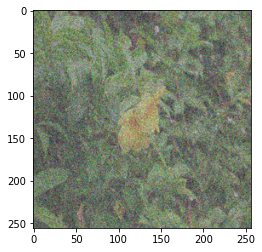

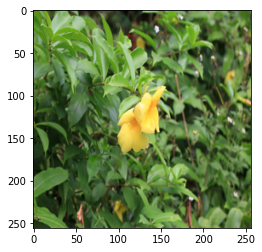

In [ ]:
i = 10
batch = 0
noise_img =(noise_valid_generator[batch][i]*255).astype(int)
plt.imshow(noise_img)
plt.show()


clean_img =(clean_valid_generator[batch][i]*255).astype(int)
plt.imshow(clean_img)
plt.show()

In [ ]:
import keras.layers as layers
import keras.models as models
from keras.initializers import orthogonal
import tensorflow as tf

def Conv2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = layers.Conv2D(filters, kernel_size=kernel, strides=strides, padding=padding,
                      kernel_initializer=kernel_init, name=prefix+'conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

def Transpose_Conv2D(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = layers.Conv2DTranspose(filters, kernel_size=kernel, strides=strides, padding=padding,
                               kernel_initializer=kernel_init, name=prefix+'de-conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x



def AutoEncdoer(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # 256 x 256
    conv1 = Conv2DLayer(inputs, 64, 3, strides=1, padding='same', block_id=1)
    conv2 = Conv2DLayer(conv1, 64, 3, strides=2, padding='same', block_id=2)
    
    # 128 x 128
    conv3 = Conv2DLayer(conv2, 128, 5, strides=2, padding='same', block_id=3)
    
    # 64 x 64
    conv4 = Conv2DLayer(conv3, 128, 3, strides=1, padding='same', block_id=4)
    conv5 = Conv2DLayer(conv4, 256, 5, strides=2, padding='same', block_id=5)
    
    # 32 x 32
    conv6 = Conv2DLayer(conv5, 512, 3, strides=2, padding='same', block_id=6)
    
    # 16 x 16
    deconv1 = Transpose_Conv2D(conv6, 512, 3, strides=2, padding='same', block_id=7)
    
    # 32 x 32
    skip1 = layers.concatenate([deconv1, conv5], name='skip1')
    conv7 = Conv2DLayer(skip1, 256, 3, strides=1, padding='same', block_id=8)
    deconv2 = Transpose_Conv2D(conv7, 128, 3, strides=2, padding='same', block_id=9)
    
    # 64 x 64
    skip2 = layers.concatenate([deconv2, conv3], name='skip2')
    conv8 = Conv2DLayer(skip2, 128, 5, strides=1, padding='same', block_id=10)
    deconv3 = Transpose_Conv2D(conv8, 64, 3, strides=2, padding='same', block_id=11)
    
    # 128 x 128
    skip3 = layers.concatenate([deconv3, conv2], name='skip3')
    conv9 = Conv2DLayer(skip3, 64, 5, strides=1, padding='same', block_id=12)
    deconv4 = Transpose_Conv2D(conv9, 64, 3, strides=2, padding='same', block_id=13)
    
    # 256 x 256
    skip3 = layers.concatenate([deconv4, conv1])
    conv10 = layers.Conv2D(3, 3, strides=1, padding='same', activation='sigmoid',
                       kernel_initializer=orthogonal(), name='final_conv')(skip3)

    
    return models.Model(inputs=inputs, outputs=conv10)

In [ ]:
tf.keras.backend.clear_session()
image_shape = (256,256)

from keras.optimizers import  Adam

model = AutoEncdoer((*image_shape, 3))
model_opt = Adam(learning_rate=0.0002)

model.compile(optimizer=model_opt, loss='mse', metrics=['mse'])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block_1_conv (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block_1_lrelu (LeakyReLU)       (None, 256, 256, 64) 0           block_1_conv[0][0]               
__________________________________________________________________________________________________
block_1_drop (Dropout)          (None, 256, 256, 64) 0           block_1_lrelu[0][0]              
______________________________________________________________________________________________

In [ ]:
modelchk = keras.callbacks.ModelCheckpoint(saved_weight, 
                                      monitor='val_mse', 
                                      verbose=1,
                                      save_best_only=True, 
                                      save_weights_only=False,
                                      mode='auto',
                                      period=3)

tensorboard = keras.callbacks.TensorBoard(log_dir=P_LOGS,
                                          histogram_freq=0,
                                          write_graph=True,
                                          write_images=True)

csv_logger = keras.callbacks.CSVLogger(f'{P_LOGS}/keras_log.csv',
                                       append=True)

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)


In [ ]:
model.fit(train_generator,
          steps_per_epoch = train_steps,
          epochs=150,
          verbose=1,
          validation_data=valid_generator,
          validation_steps = valid_steps,
          callbacks=[modelchk, tensorboard, csv_logger],
          )

Epoch 1/150
77/77 [==============================] - 1361s 18s/step - loss: 0.0380 - mse: 0.0380 - val_loss: 0.0819 - val_mse: 0.0819
Epoch 2/150
77/77 [==============================] - 505s 7s/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0567 - val_mse: 0.0567
Epoch 3/150
77/77 [==============================] - 505s 7s/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0555 - val_mse: 0.0555

Epoch 00003: val_mse improved from inf to 0.05554, saving model to /content/drive/MyDrive/BS/modeling_7/saved_models/dataweights_03_tf.tf
INFO:tensorflow:Assets written to: /content/drive/MyDrive/BS/modeling_7/saved_models/dataweights_03_tf.tf/assets
Epoch 4/150
77/77 [==============================] - 493s 6s/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 5/150
77/77 [==============================] - 477s 6s/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0628 - val_mse: 0.0628
Epoch 6/150
77/77 [==============================] - 483s 6s/step - loss: 0.0074 - mse

In [ ]:

model.save('/content/drive/MyDrive/BS/modeling_7/saved_models/as_df.h5')

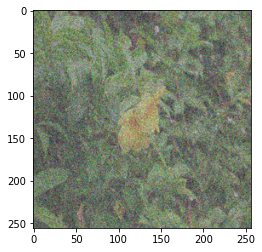

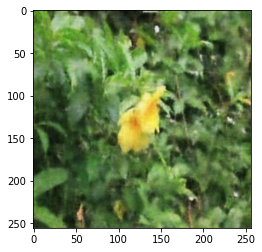

In [ ]:
i = 10

decoded_imgs = model.predict(noise_valid_generator[0])
plt.imshow((noise_valid_generator[0][i]*255).astype(int))
plt.show()


plt.imshow((decoded_imgs[i]*255).astype(int))
plt.show()


Plot and predict

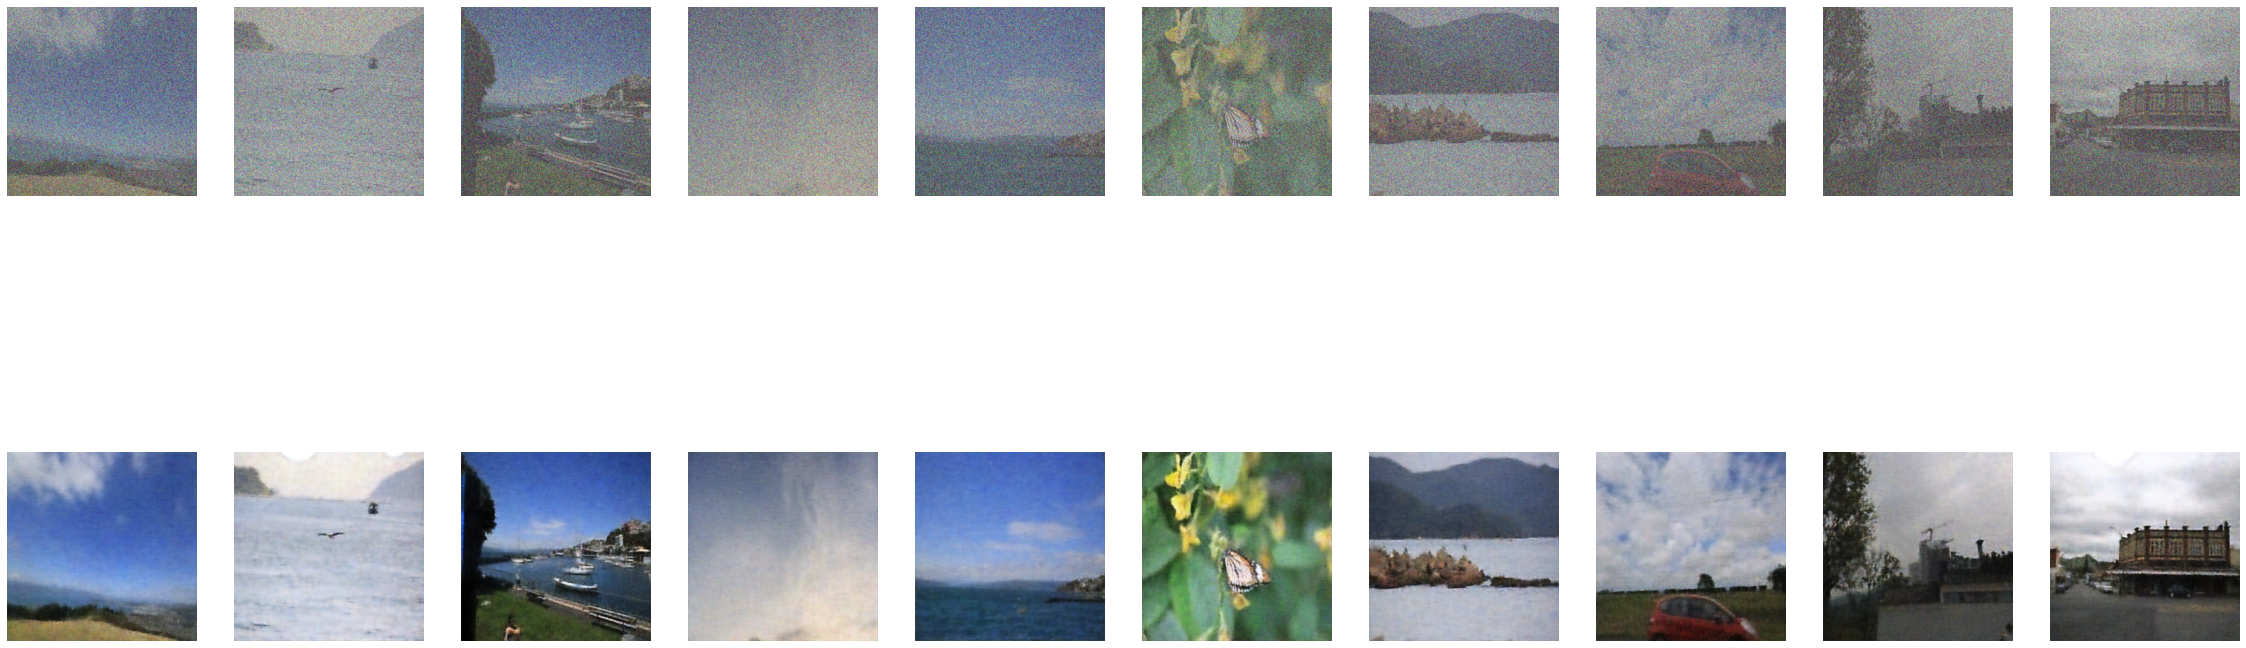

In [ ]:
import matplotlib.pyplot as plt

n = 10

plt.figure(figsize=(40, 15))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(noise_valid_generator[0][i])
    ax.axis('off')

    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    ax.axis('off')

plt.show()

In [1]:
from math import log10, sqrt
import cv2

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
  

def model_compare_image(org_path, new_path, model):
    original = cv2.imread(org_path).astype(np.float32)
    compressed_org = cv2.imread(new_path, 1).astype(np.float32)
    compressed = cv2.resize(compressed_org, (256, 256), interpolation= cv2.INTER_AREA)
    compressed /= 255.0
    compressed = compressed.reshape([1] + list(compressed.shape))
    decoded_img = model.predict(compressed)[0]
    decoded_imgs = cv2.resize(decoded_img, (original.shape[1], original.shape[0]), interpolation= cv2.INTER_AREA)
    decoded_imgs *= 255.0
    value_predict = PSNR(original, decoded_imgs)
    value_non_predict = PSNR(original, compressed_org)
    print(f"PSNR value is model predict : {value_predict} dB")
    print(f"PSNR value is w/o model     : {value_non_predict} dB")

    return value_predict, value_non_predict

In [ ]:
num = 9
GT_path_1 = f'/content/drive/MyDrive/BS/GroundTruth/GT_0{num}.png'
T_path_1 = f'/content/drive/MyDrive/BS/TASK1/Task1_0{num}.png'
model_compare_image(GT_path_1, T_path_1, model_ae)